# Training Temporal Convolutional Neural Network on Landsat Satellite Image Time Series to Detect Leafy Spurge

This Notebook aims to develop a temporal convolutional neural network based on a time series of Landsat satellite imagery and class labels from the National Land Cover Dataset (NLCD). 

Table of Contents

- Introduction
- Import packages (including Tensorflow and TemporalCNN modules)
- Define paths for model inputs (data) and model outputs (evaluation metrics)
- Read Landsat SITS data and reshape to use in a Temporal CNN
- Subset data into training, testing, and validation sets
- Build the Temporal CNN model using Keras
- Define model variables (batch size, class weights, epochs, callbacks)
- Run the model!
- Evaluate and save performance metrics
- Evaluate and save confusion matrix
- TBD...


Contributors:
Thomas Lake
Ryan Briscoe Runquist

Version: November 17 2022


# Python General Packages & Imports

In [1]:
#Script uses conda environment 'tf_gpu_earthengine' from conda env 'tf_gpu'

# Packages
import sys
import os
import pandas as pd
import numpy as np
import datetime
import pprint
import time
import math
import random
from glob import glob
from functools import reduce
from pprint import pprint
import itertools

# Plotting
import matplotlib.pyplot as plt
from IPython.display import clear_output


# Tensorflow Imports


In [2]:
# Tensorflow setup

# Tensorflow version 2.4.1
import tensorflow as tf
print(tf.__version__) 

# Keras setup.
import keras
from keras import layers
from keras.layers import Flatten
from keras import backend as K
from keras import regularizers
from keras import optimizers
from keras.regularizers import l2
from keras.layers import Input, Dense, Activation, BatchNormalization, Dropout, Flatten, Lambda, SpatialDropout1D, Concatenate
from keras.layers import Conv1D, Conv2D, AveragePooling1D, MaxPooling1D, GlobalMaxPooling1D, GlobalAveragePooling1D
from keras.callbacks import Callback, ModelCheckpoint, History, EarlyStopping
from keras.models import Model, load_model
from keras.utils.np_utils import to_categorical
from keras import backend as K


2023-02-24 11:24:07.350811: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


2.4.1


Use this chunk to check the hardware (CPU vs GPU)

In [3]:
# # Are We Using a GPU?

# import tensorflow as tf

# print(tf.config.list_physical_devices('GPU'))
# # [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# print(tf.test.is_built_with_cuda)
# # <function is_built_with_cuda at 0x7f4f5730fbf8>

# print(tf.test.gpu_device_name())
# # /device:GPU:0

# print(tf.config.get_visible_devices())
# # [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# # Matrix multiplication test with gpu

# a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
# b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
# c = tf.matmul(a, b)

# Import temporalCNN Python modules

These are a set of functions published by Pelletier et al., 2019: "Temporal convolutional neural network for the classification of satellite image time series"

https://github.com/charlotte-pel/temporalCNN/

In [4]:
import sys

# Import from ~/sits folder
# Contains readingsits.py file to read and compute and reshape the SITS data
sys.path.append("/panfs/roc/groups/7/moeller/shared/leafy-spurge-demography/temporalCNN/sits")
import readingsits

# Import from ~/deeplearning folder
# Contains multiple .py files with varying DL architectures 
sys.path.append("/panfs/roc/groups/7/moeller/shared/leafy-spurge-demography/temporalCNN/deeplearning")

import architecture_features
import architecture_complexity
import architecture_rnn
import architecture_regul
import architecture_batchsize
import architecture_depth
import architecture_spectro_temporal
import architecture_pooling

# Import from ~/outputfiles folder
# Contains evaluation.py and save.py files with fucntions to compute summary statistics, write predictions, and create confusion matrices
sys.path.append("/panfs/roc/groups/7/moeller/shared/leafy-spurge-demography/temporalCNN/outputfiles")

import evaluation
import save

# Create Model Dataset with Latitude/Longitude Coordinates Included

In [5]:
# Combine multiple CSV files with identical columns into one CSV & export

#from pathlib import Path
#import pandas as pd
#import numpy as np
#import glob

#path = r'/panfs/roc/groups/7/moeller/shared/leafy-spurge-demography/datasets_oct22' # use your path

#all_files = glob.glob(os.path.join(path, "*.csv"))

#df0 = pd.read_csv(r'/panfs/roc/groups/7/moeller/shared/leafy-spurge-demography/datasets_oct22/NLCD2001_full_dataset_oct2022.csv')
#df1 = pd.read_csv(r'/panfs/roc/groups/7/moeller/shared/leafy-spurge-demography/datasets_oct22/NLCD2004_full_dataset_oct2022.csv')
#df2 = pd.read_csv(r'/panfs/roc/groups/7/moeller/shared/leafy-spurge-demography/datasets_oct22/NLCD2006_full_dataset_oct2022.csv')
#df3 = pd.read_csv(r'/panfs/roc/groups/7/moeller/shared/leafy-spurge-demography/datasets_oct22/NLCD2008_full_dataset_oct2022.csv')
#df4 = pd.read_csv(r'/panfs/roc/groups/7/moeller/shared/leafy-spurge-demography/datasets_oct22/NLCD2011_full_dataset_oct2022.csv')
#df5 = pd.read_csv(r'/panfs/roc/groups/7/moeller/shared/leafy-spurge-demography/datasets_oct22/NLCD2013_full_dataset_oct2022.csv')
#df6 = pd.read_csv(r'/panfs/roc/groups/7/moeller/shared/leafy-spurge-demography/datasets_oct22/NLCD2016_full_dataset_oct2022.csv')
#df7 = pd.read_csv(r'/panfs/roc/groups/7/moeller/shared/leafy-spurge-demography/datasets_oct22/NLCD2019_full_dataset_oct2022.csv')

#df_full = pd.DataFrame(np.concatenate((df0.values, df1.values, df2.values, df3.values, df4.values, df5.values, df6.values, df7.values), axis=0))

#df = pd.concat((pd.read_csv(f, header=None) for f in all_files), ignore_index=True)

#print(df_full.shape)

#df_full.head()

#print(df_full.dtypes)

#Write full dataframe to csv
#df_full.to_csv('/panfs/roc/groups/7/moeller/shared/leafy-spurge-demography/datasets_oct22/NLCD_full_dataset_allyears_latlong_jan2023.csv', sep=',', header=False, index=False)


In [6]:
#from sklearn.model_selection import train_test_split

#train_df, test_df = train_test_split(df, test_size=0.1)

#Number of rows/columns in dataset
#print(train_df.shape, test_df.shape)

# Write full training and testing dataframes to CSV
# Export format as rows [classID, index, band_values/timeseries..., lat/long] with no header
#train_df.to_csv("/panfs/roc/groups/7/moeller/shared/leafy-spurge-demography/datasets_oct22/train_dataset_full_latlong_jan2023.csv", header=False)
#test_df.to_csv("/panfs/roc/groups/7/moeller/shared/leafy-spurge-demography/datasets_oct22/test_dataset_full_latlong_jan2023.csv", header=False)


In [7]:
# Export full dataset as csv
#df.head()
#df.to_csv('/panfs/roc/groups/7/moeller/shared/leafy-spurge-demography/datasets_oct22/NLCD_full_dataset_allyears_latlong_jan2023.csv', sep=',', index=False)


In [8]:
#from tensorflow.keras.utils import to_categorical
#from sklearn.model_selection import train_test_split

# Root to data folder, a training or validation file
#data_path = "/panfs/roc/groups/7/moeller/shared/leafy-spurge-demography/datasets_oct22/NLCD_full_dataset_allyears_latlong_jan2023.csv"

# Read in data file in pandas as csv
#df = pd.DataFrame(pd.read_csv(data_path, header=None))



In [9]:

#Make a 80:10:10 training, testing, and validation dataset split with the train_test_split function, twice.
#train_df, test_df = train_test_split(df, test_size=0.1, random_state=1) #Divide training and testing into 90:10 split
#train_df, valid_df = train_test_split(train_df, test_size=0.12, random_state=1) #Divide training and validation further

#print(train_df.shape)
#print(valid_df.shape)
#print(test_df.shape)

#train_df.to_csv("/panfs/roc/groups/7/moeller/shared/leafy-spurge-demography/datasets_oct22/NLCD_train_dataset_allyears_latlong_jan2023.csv", header=False, index=False)
#valid_df.to_csv("/panfs/roc/groups/7/moeller/shared/leafy-spurge-demography/datasets_oct22/NLCD_valid_dataset_allyears_latlong_jan2023.csv", header=False, index=False)
#test_df.to_csv("/panfs/roc/groups/7/moeller/shared/leafy-spurge-demography/datasets_oct22/NLCD_test_dataset_allyears_latlong_jan2023.csv", header=False, index=False)



# Set Model Paths for Input Data & Model Results Files

In [10]:
# Set a model results path
res_path = '/panfs/roc/groups/7/moeller/shared/leafy-spurge-demography/temporalCNN'

# Set Architecture / Model Run Index (used if running in batch on MSI)
noarchi = 3
norun = 1
feature = "SB" #use only spectral bands provided (do not compute new bands, like NDVI, which are already computed)
train_str = "latlong"

# Creating output path if does not exist
if not os.path.exists(res_path):
  print("ResPath DNE")
  os.makedirs(res_path)

# Output files			
res_path = res_path + '/Archi' + str(noarchi) + '/'
if not os.path.exists(res_path):
  os.makedirs(res_path)
  print("noarchi: ", noarchi)

# Create output files to capture model results
str_result = feature + '-' + train_str + '-noarchi' + str(noarchi) + '-norun-' + str(norun)

# Output for model evaluation metrics
res_file = res_path + 'result_accuracy_metrics-' + str_result + '.txt'

# Output for model loss / epochs
traintest_loss_file = res_path + 'trainingHistory-' + str_result + '.txt'

# Output for confusion matrix
conf_file = res_path + 'confMatrix-' + str_result + '.txt'

# Output for model weights file (.h5 file)
out_model_file = res_path + 'model-' + str_result + '.h5'

print("Model accuracy metrics: " + res_file)
print("Model history: " + traintest_loss_file)
print("Model confusion matrix: " + conf_file)
print("Model weights: " + out_model_file)


Model accuracy metrics: /panfs/roc/groups/7/moeller/shared/leafy-spurge-demography/temporalCNN/Archi3/result_accuracy_metrics-SB-latlong-noarchi3-norun-1.txt
Model history: /panfs/roc/groups/7/moeller/shared/leafy-spurge-demography/temporalCNN/Archi3/trainingHistory-SB-latlong-noarchi3-norun-1.txt
Model confusion matrix: /panfs/roc/groups/7/moeller/shared/leafy-spurge-demography/temporalCNN/Archi3/confMatrix-SB-latlong-noarchi3-norun-1.txt
Model weights: /panfs/roc/groups/7/moeller/shared/leafy-spurge-demography/temporalCNN/Archi3/model-SB-latlong-noarchi3-norun-1.h5


# Data Generator for Spectral & Positional Data
# Training Data

In [11]:
from tensorflow.keras.utils import to_categorical

# Read training set dataframe
train_df = pd.DataFrame(pd.read_csv("/panfs/roc/groups/7/moeller/shared/leafy-spurge-demography/datasets_oct22/NLCD_train_dataset_allyears_latlong_jan2023.csv"))
#train_df.head()
#print(train_df.shape)
nchannels = 7 #-- B G NDVI NIR Red SWIR1 SWIR2

# Select spectral data (first 63 columns)
batch_X = train_df.iloc[:, 1:64].to_numpy()
batch_X_spectral = batch_X.reshape(batch_X.shape[0],int(batch_X.shape[1]/nchannels),nchannels)
#print(batch_X_spectral[0])
#print(batch_X_spectral.shape)

# Select latitude/longitude coordinates (get last 3 columns, remove last 1 (class) column)
batch_X_coords = train_df.iloc[:, -3:].iloc[:, :-1].to_numpy()
#print(batch_X_coords.shape)

# Add X data(lat/long coordinates and spectral data) as list to X_train
# Add Y data(class) to Y_train
X_train = [batch_X_coords, batch_X_spectral]

# Select class data from last column
y_train = np.asarray(train_df.iloc[:, -1]).astype(int)
#print(batch_Y.shape)
#print(batch_Y)
y_train_one_hot = to_categorical(y_train)
#print(Y_one_hot.shape)

print(X_train[0].shape, X_train[1].shape, y_train_one_hot.shape)


#print(X_train.shape, y_train_one_hot.shape, X_val.shape, y_val_one_hot.shape, X_test.shape, y_test_one_hot.shape)



(4896851, 2) (4896851, 9, 7) (4896851, 10)


# Testing Data

In [12]:

# Read validation set dataframe
test_df = pd.DataFrame(pd.read_csv("/panfs/roc/groups/7/moeller/shared/leafy-spurge-demography/datasets_oct22/NLCD_test_dataset_allyears_latlong_jan2023.csv"))
#test_df.head()
#print(test_df.shape)
nchannels = 7 #-- B G NDVI NIR Red SWIR1 SWIR2

# Select spectral data (first 63 columns)
batch_X = test_df.iloc[:, 1:64].to_numpy()
batch_X_spectral = batch_X.reshape(batch_X.shape[0],int(batch_X.shape[1]/nchannels),nchannels)
#print(batch_X_spectral[0])
#print(batch_X_spectral.shape)

# Select latitude/longitude coordinates (get last 3 columns, remove last 1 (class) column)
batch_X_coords = test_df.iloc[:, -3:].iloc[:, :-1].to_numpy()
#print(batch_X_coords.shape)

# Add X data(lat/long coordinates and spectral data) as list to X_test
# Add Y data(class) to Y_test
X_test = [batch_X_coords, batch_X_spectral]

# Select class data from last column
y_test = np.asarray(test_df.iloc[:, -1]).astype(int)
#print(batch_Y.shape)
#print(batch_Y)
y_test_one_hot = to_categorical(y_test)
#print(Y_one_hot.shape)

print(X_test[0].shape, X_test[1].shape, y_test_one_hot.shape)





(618289, 2) (618289, 9, 7) (618289, 10)


# Validation Data

In [13]:

# Read validation set dataframe
valid_df = pd.DataFrame(pd.read_csv("/panfs/roc/groups/7/moeller/shared/leafy-spurge-demography/datasets_oct22/NLCD_valid_dataset_allyears_latlong_jan2023.csv"))
#valid_df.head()
#print(valid_df.shape)
nchannels = 7 #-- B G NDVI NIR Red SWIR1 SWIR2

# Select spectral data (first 63 columns)
batch_X = valid_df.iloc[:, 1:64].to_numpy()
batch_X_spectral = batch_X.reshape(batch_X.shape[0],int(batch_X.shape[1]/nchannels),nchannels)
#print(batch_X_spectral[0])
#print(batch_X_spectral.shape)

# Select latitude/longitude coordinates (get last 3 columns, remove last 1 (class) column)
batch_X_coords = valid_df.iloc[:, -3:].iloc[:, :-1].to_numpy()
#print(batch_X_coords.shape)

# Add X data(lat/long coordinates and spectral data) as list to X_valid
# Add Y data(class) to Y_valid
X_valid = [batch_X_coords, batch_X_spectral]

# Select class data from last column
y_valid = np.asarray(valid_df.iloc[:, -1]).astype(int)
#print(batch_Y.shape)
#print(batch_Y)
y_valid_one_hot = to_categorical(y_valid)
#print(Y_one_hot.shape)

print(X_valid[0].shape, X_valid[1].shape, y_valid_one_hot.shape)


(667752, 2) (667752, 9, 7) (667752, 10)


# Define Temporal CNN Model Components


In [14]:

#Build the Temporal CNN 
from keras.layers.merge import concatenate
from keras.models import Model, Sequential
from keras.layers import Dense, Input

#Get model input sizes
input_shape = (9, 7) #spectral data dimensions (batch size, timesteps, channels)
input_coords_shape = (2,) #lat long coords (batch size, [lat, long])

# Model 1
    # Latitude/Longitude Spatial Encoding
    # Define Input for Spatial Data
X_coords_input = Input(shape=(input_coords_shape))
    #-- lat long coordinates fc + relu
model1_out = Dense(576, activation='relu')(X_coords_input) #Dense 576 = 9 (timesteps) * 64 (conv1d filters)
model1 = Model(inputs = [X_coords_input],  outputs = [model1_out])

# Model 2
    # Temporal Convolutional Neural Network (1D-CNN)
#-- parameters of the architecture
nbclasses = 10 # number of classes for output
l2_rate = 1.e-6 # regularization
dropout_rate = 0.1 # regularization
nbunits_conv = 64 #-- convolution filters, will be double
nbunits_fc = 128 #-- fully connected (dense) layer, will be double    
    
	# Define the input placeholders.
X_input = Input(input_shape) # (batch size, timesteps, channels)
    #-- Conv BN Activation Dropout
X = Conv1D(nbunits_conv, 5, strides = 1, padding="same", kernel_initializer="he_normal", kernel_regularizer=l2(l2_rate))(X_input)
X = BatchNormalization(axis=-1)(X)
X = Activation('relu')(X)
X = Dropout(dropout_rate)(X)
X = Conv1D(nbunits_conv, 5, strides = 1, padding="same", kernel_initializer="he_normal", kernel_regularizer=l2(l2_rate))(X)
X = BatchNormalization(axis=-1)(X)
X = Activation('relu')(X)
X = Dropout(dropout_rate)(X)
X = Conv1D(nbunits_conv, 5, strides = 1, padding="same", kernel_initializer="he_normal", kernel_regularizer=l2(l2_rate))(X)
X = BatchNormalization(axis=-1)(X)
X = Activation('relu')(X)
X = Dropout(dropout_rate)(X)
model2_out = Flatten()(X)
model2 = Model(inputs = [X_input], outputs = [model2_out])

# Combine two models on common axis 576
concatenated = Concatenate(axis=-1)([model1_out, model2_out])

# Model 3 (combined model)
    # Fully connected layer and softmax output
Z = Dense(nbunits_fc, kernel_initializer="he_normal", kernel_regularizer=l2(l2_rate))(concatenated)
Z = BatchNormalization(axis=-1)(Z)
Z = Activation('relu')(Z)
Z = Dropout(dropout_rate)(Z)
	#-- SOFTMAX layer
out = Dense(nbclasses, activation='softmax', kernel_initializer="he_normal",kernel_regularizer=l2(l2_rate))(Z)

# Create merged model.
merged_model = Model(inputs = [X_coords_input, X_input], outputs = out)


2023-02-24 11:25:04.663911: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-02-24 11:25:04.667061: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-02-24 11:25:07.647326: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:02:00.0 name: Tesla K40m computeCapability: 3.5
coreClock: 0.745GHz coreCount: 15 deviceMemorySize: 11.17GiB deviceMemoryBandwidth: 268.58GiB/s
2023-02-24 11:25:07.647384: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-02-24 11:25:08.028942: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-02-24 11:25:08.029012: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2023-02-24

# Create the Deep Learning Model in Keras

Before we create the model, there's still a wee bit of pre-processing to get the data into the right input shape and a format that can be used with cross-entropy loss. Specifically, Keras expects a list of inputs and a one-hot vector for the class. (See the Keras loss function docs, the TensorFlow categorical identity docs and the tf.one_hot docs for details).

Here we will use a simple neural network model with a 64 node hidden layer, a dropout layer and an output layer. Once the dataset has been prepared, define the model, compile it, fit it to the training data. See the Keras Sequential model guide for more details.

In [15]:

#Define Class Weights
from sklearn.utils import class_weight

class_weights =  class_weight.compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(y_train),
                                        y = y_train)

class_weights = dict(zip(np.unique(y_train), class_weights))

# Class weights function
# inverse of frequency?
class_weights = {0: 0,
                 1: 1.046028630719989,
                 2: 1.6421837069230087,
                 3: 1.37461158722999,
                 4: 0.7614511317372198,
                 5: 0.6015453322153169,
                 6: 0.3652990948014909,
                 7: 0.39487324200412083,
                 8: 4.334510403657227,
                 9: 13}

print(class_weights)


# Set Model variables
n_epochs = 100
batch_size = 10192
lr = 0.0001 # initial learning rate for optimizer (see below: learning rate scheduler for warmup and cosine decay)
beta_1 = 0.9
beta_2 = 0.98
epsilon = 1e-07

#Model Optimizer (adam)
opt = tf.keras.optimizers.Adam(lr=lr, beta_1=beta_1, beta_2=beta_2, epsilon=epsilon)

# Set Loss function 
cce = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1)

# Compile Model
merged_model.compile(optimizer = opt, loss = cce, metrics = ["accuracy"])

merged_model.summary()




{0: 0, 1: 1.046028630719989, 2: 1.6421837069230087, 3: 1.37461158722999, 4: 0.7614511317372198, 5: 0.6015453322153169, 6: 0.3652990948014909, 7: 0.39487324200412083, 8: 4.334510403657227, 9: 13}
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 9, 7)]       0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 9, 64)        2304        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 9, 64)        256         conv1d[0][0]                     
_______________________________________________________________________________________________

# Model callbacks: Checkpoint, Early Stopping, Plot Losses (interactively)

In [16]:

# Save Model at Regular Checkpoints
checkpoint = ModelCheckpoint(out_model_file, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=2, verbose=1, mode='auto', restore_best_weights=False)

#Plot Loss and Accuracy Callback
class PlotLearning(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.f1 = []
        self.val_f1 = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.f1.append(logs.get('accuracy'))
        self.val_f1.append(logs.get('val_accuracy'))
        self.i += 1
        f, (ax1, ax2) = plt.subplots(1, 2, sharex=True)
        
        clear_output(wait=True)
        
        ax1.set_yscale('log')
        ax1.plot(self.x, self.losses, label="loss")
        ax1.plot(self.x, self.val_losses, label="val loss")
        ax1.legend()
        
        ax2.plot(self.x, self.f1, label="Acc")
        ax2.plot(self.x, self.val_f1, label="val Acc ")
        ax2.legend()
        
        plt.show();
        
plot_losses = PlotLearning()

class LROutput(Callback):
    def on_epoch_end(self, epoch, logs=None):
        lr = self.model.optimizer.lr
        print(lr)
        
lr_output = LROutput()


# Model Callback: Warmup Learning Rate

In [17]:

def cosine_decay_with_warmup(global_step,
                             learning_rate_base,
                             total_steps,
                             warmup_learning_rate=0.0,
                             warmup_steps=0,
                             hold_base_rate_steps=0):
    """Cosine decay schedule with warm up period.
    Cosine annealing learning rate as described in:
      Loshchilov and Hutter, SGDR: Stochastic Gradient Descent with Warm Restarts.
      ICLR 2017. https://arxiv.org/abs/1608.03983
    In this schedule, the learning rate grows linearly from warmup_learning_rate
    to learning_rate_base for warmup_steps, then transitions to a cosine decay
    schedule.
    Arguments:
        global_step {int} -- global step.
        learning_rate_base {float} -- base learning rate.
        total_steps {int} -- total number of training steps.
    Keyword Arguments:
        warmup_learning_rate {float} -- initial learning rate for warm up. (default: {0.0})
        warmup_steps {int} -- number of warmup steps. (default: {0})
        hold_base_rate_steps {int} -- Optional number of steps to hold base learning rate
                                    before decaying. (default: {0})
    Returns:
      a float representing learning rate.
    Raises:
      ValueError: if warmup_learning_rate is larger than learning_rate_base,
        or if warmup_steps is larger than total_steps.
    """

    if total_steps < warmup_steps:
        raise ValueError('total_steps must be larger or equal to '
                         'warmup_steps.')
    learning_rate = 0.5 * learning_rate_base * (1 + np.cos(
        np.pi *
        (global_step - warmup_steps - hold_base_rate_steps
         ) / float(total_steps - warmup_steps - hold_base_rate_steps)))
    if hold_base_rate_steps > 0:
        learning_rate = np.where(global_step > warmup_steps + hold_base_rate_steps,
                                 learning_rate, learning_rate_base)
    if warmup_steps > 0:
        if learning_rate_base < warmup_learning_rate:
            raise ValueError('learning_rate_base must be larger or equal to '
                             'warmup_learning_rate.')
        slope = (learning_rate_base - warmup_learning_rate) / warmup_steps
        warmup_rate = slope * global_step + warmup_learning_rate
        learning_rate = np.where(global_step < warmup_steps, warmup_rate,
                                 learning_rate)
    return np.where(global_step > total_steps, 0.0, learning_rate)


class WarmUpCosineDecayScheduler(keras.callbacks.Callback):
    """Cosine decay with warmup learning rate scheduler
    """

    def __init__(self,
                 learning_rate_base,
                 total_steps,
                 global_step_init=0,
                 warmup_learning_rate=0.0,
                 warmup_steps=0,
                 hold_base_rate_steps=0,
                 verbose=0):
        """Constructor for cosine decay with warmup learning rate scheduler.
    Arguments:
        learning_rate_base {float} -- base learning rate.
        total_steps {int} -- total number of training steps.
    Keyword Arguments:
        global_step_init {int} -- initial global step, e.g. from previous checkpoint.
        warmup_learning_rate {float} -- initial learning rate for warm up. (default: {0.0})
        warmup_steps {int} -- number of warmup steps. (default: {0})
        hold_base_rate_steps {int} -- Optional number of steps to hold base learning rate
                                    before decaying. (default: {0})
        verbose {int} -- 0: quiet, 1: update messages. (default: {0})
        """

        super(WarmUpCosineDecayScheduler, self).__init__()
        self.learning_rate_base = learning_rate_base
        self.total_steps = total_steps
        self.global_step = global_step_init
        self.warmup_learning_rate = warmup_learning_rate
        self.warmup_steps = warmup_steps
        self.hold_base_rate_steps = hold_base_rate_steps
        self.verbose = verbose
        self.learning_rates = []

    def on_batch_end(self, batch, logs=None):
        self.global_step = self.global_step + 1
        lr = K.get_value(self.model.optimizer.lr)
        self.learning_rates.append(lr)

    def on_batch_begin(self, batch, logs=None):
        lr = cosine_decay_with_warmup(global_step=self.global_step,
                                      learning_rate_base=self.learning_rate_base,
                                      total_steps=self.total_steps,
                                      warmup_learning_rate=self.warmup_learning_rate,
                                      warmup_steps=self.warmup_steps,
                                      hold_base_rate_steps=self.hold_base_rate_steps)
        K.set_value(self.model.optimizer.lr, lr)
        if self.verbose > 0:
            print('\nBatch %05d: setting learning '
                  'rate to %s.' % (self.global_step + 1, lr))


   
# Number of training samples (rows).
sample_count = X_train[0].shape[0]

# Total epochs to train.
epochs = n_epochs

# Number of warmup epochs. (10% of total epochs)
warmup_epoch = 10

# Training batch size, set small value here for demonstration purpose.
batch_size = batch_size

# Base learning rate after warmup.
learning_rate_base = 0.001

total_steps = int(epochs * sample_count / batch_size) #98,275

# Compute the number of warmup batches.
warmup_steps = int(warmup_epoch * sample_count / batch_size) #9827

# Compute the number of warmup batches.
warmup_batches = warmup_epoch * sample_count / batch_size

# Create the Learning rate scheduler.
warm_up_lr = WarmUpCosineDecayScheduler(learning_rate_base=learning_rate_base,
                                        total_steps=total_steps,
                                        warmup_learning_rate=0.0,
                                        warmup_steps=warmup_steps,
                                        hold_base_rate_steps=0)


# Model Training

In [20]:
#Train the model
start_train_time = time.time()

# Fit the model
hist = merged_model.fit(x = X_train, 
                 y = y_train_one_hot, 
                 epochs = 10,
                 batch_size = batch_size,
                 validation_data = (X_valid, y_valid_one_hot),
                 shuffle=True,
                 verbose=1,
                 class_weight = class_weights,
                 callbacks = [warm_up_lr])


train_time = round(time.time()-start_train_time, 2)


2023-02-24 11:33:42.116297: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1234006452 exceeds 10% of free system memory.


Epoch 1/10
481/481 [==============================] - 37s 76ms/step - loss: 0.8168 - accuracy: 0.7379 - val_loss: 1.1003 - val_accuracy: 0.7522
Epoch 2/10
481/481 [==============================] - 37s 76ms/step - loss: 0.8118 - accuracy: 0.7404 - val_loss: 1.0623 - val_accuracy: 0.7566
Epoch 3/10
481/481 [==============================] - 37s 76ms/step - loss: 0.8078 - accuracy: 0.7423 - val_loss: 1.3628 - val_accuracy: 0.6229
Epoch 4/10
481/481 [==============================] - 37s 76ms/step - loss: 0.8041 - accuracy: 0.7438 - val_loss: 1.3991 - val_accuracy: 0.6018
Epoch 5/10
481/481 [==============================] - 37s 76ms/step - loss: 0.8010 - accuracy: 0.7454 - val_loss: 1.1655 - val_accuracy: 0.7328
Epoch 6/10
481/481 [==============================] - 37s 76ms/step - loss: 0.7978 - accuracy: 0.7467 - val_loss: 1.3591 - val_accuracy: 0.6317
Epoch 7/10
481/481 [==============================] - 37s 76ms/step - loss: 0.7947 - accuracy: 0.7480 - val_loss: 1.1442 - val_accuracy:

# Save the trained model

In [18]:

# Save the Trained Model as a .h5 file
merged_model.save(r'/panfs/roc/groups/7/moeller/shared/leafy-spurge-demography/temporalCNN/Archi3/TemporalCNN_300epochs_baseline_latlongencoding_feb242023.h5')
           
           

# Load a trained model

In [21]:

# Load a trained model
model = keras.models.load_model(r'/panfs/roc/groups/7/moeller/shared/leafy-spurge-demography/temporalCNN/Archi1/TemporalCNN_100epochs_baseline_latlongencoding_jan242023.h5')


# Predict a .tif image using a model with latitude/longitude and spectral data

For exporting only the leafy spurge softmax layer, replace 'dst.write(pim3, 1)' with 'dst.write(pim[:, :, 9], 1)' below.

In [ ]:

#Model Prediction on small TIF raster file

import rasterio as rio
from rasterio.plot import show
import glob
import time
import itertools

# Input prediction .tif path
image_path = r'/panfs/roc/groups/7/moeller/shared/leafy-spurge-demography/landsat_tifs_2019/'

# Output prediction file path
outpath = r'/panfs/roc/groups/7/moeller/shared/leafy-spurge-demography/datasets_oct22/raster_preds_exp'

# List all .tif files in /rasters folder for prediction
tif_image_list = glob.glob(image_path + '*.tif')

print(tif_image_list[0])

# Loop through every tif file for prediction.
for t in range(len(tif_image_list)):
    
    prediction_train_time = time.time()
    
    with rio.open(tif_image_list[t], 'r') as dataset:
        # First, get the coordinates of every pixel in the .tif image
        # Define shape of .tif image
        shape = dataset.shape
        nodata = dataset.nodata
        
        #Get the X,Y coordinates (lat/long) for each dataset (image) and index as np array
        xy1, xy2 = itertools.tee(dataset.xy(x, y) for x, y in np.ndindex(shape))  # save re-running dataset.xy
        data = ((x, y, z[0]) for (x, y), z in zip(xy1, dataset.sample(xy2)) if z[0] != nodata)
        res = pd.DataFrame(data, columns=["lon", "lat", "data"])
        coords = res.to_numpy() #convert to numpy array
        coords2 = coords[:,0:2] # Remove 'data' column, make latitude come before longitude
        coords2[:,[1,0]] = coords2[:,[0,1]] # swap longitude and latitude columns
        #print(coords2[1:10, :], coords2.shape)
        print("Got Coordinates of Landsat Image \n")
        
        # Second, get the spectral data from every pixel in the .tif image
        arr = dataset.read()
        # Define shape of input .tif image
        bands, width, height = arr.shape

        # Convert Tif Data Type to float32 by division.
        arr = arr/10000

        # Reshape .tif array axes for correct format so model can predict.
        arr = np.moveaxis(arr, 0, -1) #move axis to channels last
        new_arr = arr.reshape(-1, arr.shape[-1]) #reshape to row and column
        num_pixels = width*height
        spectral = new_arr.reshape(num_pixels, 9, 7)
        print(spectral.shape)

        #combine both latitude/longitude and spectral data into list for model prediction
        X_pred = [coords2, spectral]
        print("Got Spectral Data\n")

        # Predict model and reshape to export.
        p = model.predict(X_pred) # p is prediction from the DL model
        pim = p.reshape(width, height, 10) # Dimension of prediction in rows, columns, bands (10 classes)
        pim2 = np.moveaxis(pim, 2, 0) # move axis so bands is first

        # Experimental Feb-23 - normalize the prediction (pim) for leafy spurge
        def normalize_array(arr):
            min_value = np.min(arr)
            max_value = np.max(arr)
            return (arr - min_value) / (max_value - min_value)
        
        pim_normalize_ls = normalize_array(pim[:, :, 9])
        
        # ArgMax for Segmentation.
        pim3 = np.argmax(pim2, axis=0) # take softmax of predictions for segmentation
        print(pim3.shape)

        # Get the file name (landsat_image_170_t.tif) by splitting input path.
        fileout_string = os.path.split(tif_image_list[t])

        # Output prediction raster .
        out_meta = dataset.meta.copy()

        # Get Output metadata.
        out_meta.update({'driver':'GTiff',
                         'width':dataset.shape[1],
                         'height':dataset.shape[0],
                         'count':1,
                         'dtype':'float64',
                         'crs':dataset.crs, 
                         'transform':dataset.transform,
                         'nodata':0})

        # Write predicted raster to file.
        #with rio.open(fp=outpath + "/prediction_" + fileout_string[-1], #outputpath_name
        #             mode='w',**out_meta) as dst:
        #             dst.write(pim3, 1) # the numer one is the number of bands

        #print("Writing file... \n")
        #prediction_time = round(time.time()-prediction_train_time, 2)
        #print(prediction_time)
    


# Evaluate model losses and accuracy and save outputs

In [31]:
# Evaluate the model prediction

from sklearn.metrics import multilabel_confusion_matrix
from tabulate import tabulate

# Predict the model on withheld testing dataset
y_pred = model.predict(X_test)

y_pred = np.argmax(y_pred, axis=-1)
y_pred_flat = y_pred.flatten()
y_pred_flat = y_pred_flat.astype(int)

y_test = y_test.astype(int)    
y_test_flat = y_test.flatten()


# Calculate confusion matrix
class_names = ["Water", "Developed", "BarrenLand", "Forest", "Shrub/Scrub", "Grassland/Herbaceous", "Croplands", "EmergentWetlands", "LeafySpurge"]
class_labels = [1, 2, 3, 4, 5, 6, 7, 8, 9]
c = multilabel_confusion_matrix(y_test_flat, y_pred_flat, labels = class_labels)
model_output_metrics = []
for i in range(len(class_labels)):
    tn=c[i, 0, 0]
    tp=c[i, 1, 1]
    fn=c[i, 1, 0]
    fp=c[i, 0, 1]
    accuracy = (tp+tn)/(tp+tn+fp+fn)
    TPR_Sens_Recall = tp/(tp+fn)
    TNR_Spec = tn/(tn+fp)
    FPR = fp/(fp+tn)
    FNR = fn/(fn+tp)
    precision = tp/(tp+fp)
    jaccard = tp/(tp+fp+fn)
    beta = 0.5
    F05 = ((1 + beta**2) * precision * TPR_Sens_Recall) / (beta**2 * precision + TPR_Sens_Recall)
    beta = 1
    F1 = ((1 + beta**2) * precision * TPR_Sens_Recall) / (beta**2 * precision + TPR_Sens_Recall)
    beta = 2
    F2 = ((1 + beta**2) * precision * TPR_Sens_Recall) / (beta**2 * precision + TPR_Sens_Recall)
    outputs = [class_names[i], tp, tn, fp, fn, accuracy, TPR_Sens_Recall, TNR_Spec, FPR, FNR, precision, jaccard, F1]
    model_output_metrics.append(outputs)

# Print and format outputs
print(tabulate(model_output_metrics, floatfmt=".2f", headers=["Class Name", "TP", "TN", "FP", "FN", "Accuracy", "TPR/Sens/Recall", "TNR/Spec", "FPR", "FNR", "Precision", "Jaccard", "F1"]))

#Save model results to file
#with open(res_file, 'w') as f:
#    f.write(tabulate(model_output_metrics, floatfmt=".2f", headers=["Class Name", "TP", "TN", "FP", "FN", "Accuracy", "TPR/Sens/Recall", "TNR/Spec", "FPR", "FNR", "Precision", "Jaccard", "F1"]))
    

# Save losses and accuracy
train_loss = hist.history['loss']
val_loss   = hist.history['val_loss']
train_acc  = hist.history['accuracy']
val_acc    = hist.history['val_accuracy']
xc         = range(n_epochs)

traintest_loss_df = pd.DataFrame(
    {'train_loss': train_loss,
    'val_loss': val_loss,
    'train_acc': train_acc,
    'val_acc': val_acc,
    'epochs': xc
    })

traintest_loss_df
    
#np.savetxt(traintest_loss_file, traintest_loss_df, fmt='%6f')



Class Name                   TP         TN        FP        FN    Accuracy    TPR/Sens/Recall    TNR/Spec    FPR    FNR    Precision    Jaccard    F1
--------------------  ---------  ---------  --------  --------  ----------  -----------------  ----------  -----  -----  -----------  ---------  ----
Water                   8560.00  607672.00   1002.00   1055.00        1.00               0.89        1.00   0.00   0.11         0.90       0.81  0.89
Developed               7821.00  595534.00   3829.00  11105.00        0.98               0.41        0.99   0.01   0.59         0.67       0.34  0.51
BarrenLand              1248.00  615000.00   1110.00    931.00        1.00               0.57        1.00   0.00   0.43         0.53       0.38  0.55
Forest                 81935.00  510170.00  17933.00   8251.00        0.96               0.91        0.97   0.03   0.09         0.82       0.76  0.86
Shrub/Scrub            68902.00  488260.00  15831.00  45296.00        0.90               0.60       

TypeError: 'int' object is not subscriptable

In [30]:

# Save losses and accuracy
train_loss = hist.history['loss']
val_loss   = hist.history['val_loss']
train_acc  = hist.history['accuracy']
val_acc    = hist.history['val_accuracy']
xc         = range(n_epochs)

len(train_loss)
len(val_loss)
len(train_acc)
len(val_acc)
len(xc)

300

# Calculate confusion matrix for model and save outputs

Normalized confusion matrix


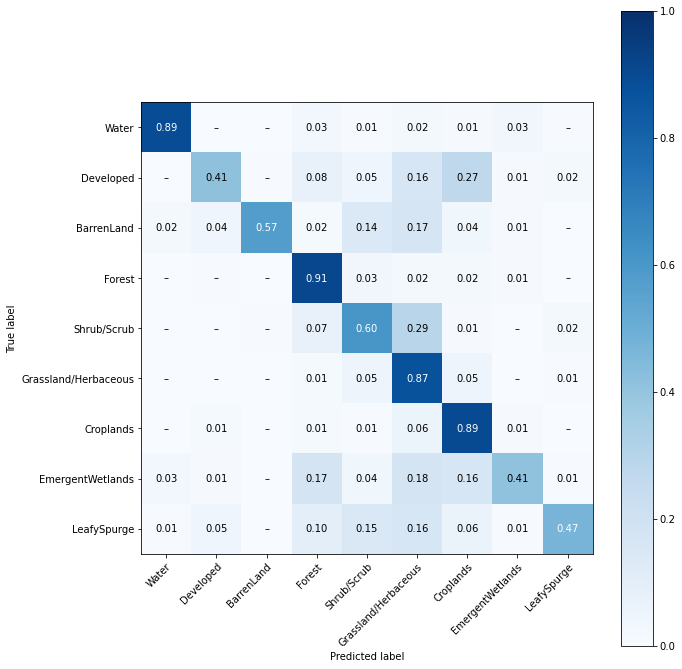

In [32]:

import os
import sys
from glob import glob
from tqdm import tqdm
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from skimage.io import imread, imshow, imsave
from sklearn.metrics import multilabel_confusion_matrix, confusion_matrix, cohen_kappa_score, accuracy_score, f1_score, precision_score, recall_score, jaccard_score, fbeta_score
from tensorflow.keras.models import load_model
from tabulate import tabulate

def plot_confusion_matrix(
        y_true,
        y_pred,
        classes,
        test_name,
        normalize=False,
        set_title=False,
        save_fig=False,
        cmap=plt.cm.Blues
):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    if set_title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    # and save it to log file
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
        #with open(f'F:/PlanetScope_LSTM_Imagery/reports/logs_and_plots/{test_name}_log.txt', 'ab') as f:
        #    f.write(b'\nNormalized confusion matrix\n')
        #    np.savetxt(f, cm, fmt='%.3f')
    else:
        print('Confusion matrix, without normalization')
        #with open(f'F:/PlanetScope_LSTM_Imagery/reports/logs_and_plots/{test_name}_log.txt', 'ab') as f:
        #    f.write(b'\nConfusion matrix, without normalization\n')
        #    np.savetxt(f, cm, fmt='%7u')

    #print(cm)
    #cm = cm[1:10]
    #cm = cm[:,1:]

    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    if normalize:
        im.set_clim(0., 1.)     # fixes missing '1.0' tick at top of colorbar
    cb = ax.figure.colorbar(im, ax=ax)
    if normalize:
        cb.set_ticks(np.arange(0., 1.2, 0.2))
        cb.set_ticklabels([f'{i/5:.1f}' for i in range(6)])
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title if set_title else None,
           ylabel='True label',
           xlabel='Predicted label')
    ax.set_ylim(len(cm)-0.5, -0.5)
    ax.xaxis.label.set_size(10)
    ax.yaxis.label.set_size(10)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            if np.round(cm[i, j], 2) > 0.:
                ax.text(j, i, format(cm[i, j], fmt),
                        ha="center", va="center",
                        color="white" if cm[i, j] > thresh else "black")
            else:
                ax.text(j, i, '–',
                        ha="center", va="center",
                        color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()

    if save_fig:
        if normalize:
            plt.savefig(f'F:/PlanetScope_LSTM_Imagery/reports/logs_and_plots/{test_name}_cm_normal.pdf')
        else:
            plt.savefig(f'F:/PlanetScope_LSTM_Imagery/reports/logs_and_plots/{test_name}_cm_non_normal.pdf')
    return fig, ax, cm




inv_category_dict = {1:"Water", 2:"Developed", 3:"BarrenLand", 4:"Forest", 5:"Shrub/Scrub", 6:"Grassland/Herbaceous", 7:"Croplands", 8:"EmergentWetlands", 9:"LeafySpurge"}

class_names = [inv_category_dict[i] for i in np.arange(1, 10)]


# save plot of normalized cm
cm = plot_confusion_matrix(
    y_test_flat,
    y_pred_flat,
    classes=class_names,
    test_name="myModel",
    normalize=True,
    save_fig=False
)

conf_df = pd.DataFrame(cm[2], columns = ["Water", "Developed", "BarrenLand", "Forest", "Shrub/Scrub", "Grassland/Herbaceous", "Croplands", "EmergentWetlands", "LeafySpurge"])

#np.savetxt(conf_file, conf_df, fmt='%6f')
